In [16]:
import requests
import pandas as pd

# Fetch data from the API for training (1 year) and testing (1 month)
url_train = "https://api.energy-charts.info/price?bzn=DE-LU&start=2024-01-01&end=2024-09-01"
url_test = "https://api.energy-charts.info/price?bzn=DE-LU&start=2024-09-01&end=2024-10-01"

response_train = requests.get(url_train)
response_test = requests.get(url_test)

data_train = response_train.json()
data_test = response_test.json()

# Convert to DataFrame
train_df = pd.DataFrame({
    'timestamp': pd.to_datetime(data_train['unix_seconds'], unit='s'),
    'price': data_train['price']
})
test_df = pd.DataFrame({
    'timestamp': pd.to_datetime(data_test['unix_seconds'], unit='s'),
    'price': data_test['price']
})

# Clean the data (remove rows with null prices)
train_df = train_df.dropna()
test_df = test_df.dropna()

# Rename columns for NeuralForecast
train_df = train_df.rename(columns={'timestamp': 'ds', 'price': 'y'})
test_df = test_df.rename(columns={'timestamp': 'ds', 'price': 'y'})
train_df['unique_id'] = 'electricity_prices'
test_df['unique_id'] = 'electricity_prices'

# Check date ranges
print("Last date in train_df:", train_df['ds'].max())
print("First date in test_df:", test_df['ds'].min())

Last date in train_df: 2024-09-01 21:00:00
First date in test_df: 2024-08-31 22:00:00


In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
import pandas as pd

horizon = 24
historical = 24 * 3

# Set up the model with horizon = 24 (for day-ahead hourly forecasts)
models = [
    LSTM(h=horizon,  # Forecast horizon set to 24 to predict the next day's 24 hours
         input_size=historical, # Input size regarding how much info the model gets to forecast the next day
         max_steps=2000,
         scaler_type='standard',
         encoder_n_layers=2,
         encoder_hidden_size=100,  # Defines the size of the hidden state of the LSTM
         decoder_hidden_size=512,
         ),
]

# Train the model on the entire training data just once
nf = NeuralForecast(models=models, freq='H')
nf.fit(df=train_df)

In [ ]:
# Define the date range based on the test dataset
daterange = pd.date_range(
    start=test_df['ds'].min(),
    end=test_df['ds'].max() - pd.Timedelta(hours=historical),
    freq='24H'
)

# Generate predictions for each 7-day window
predictions = [
    nf.predict(test_df[(test_df['ds'] >= d) & (test_df['ds'] < d + pd.Timedelta(hours=historical))])
    for d in daterange
]

# Flatten the predictions into a DataFrame
forecast_df = pd.concat(predictions, ignore_index=True)

# Ensure the results align with the test dataset
forecast_df = forecast_df[['ds', 'LSTM']].merge(test_df[['ds', 'y']], on='ds', how='inner')
forecast_df.rename(columns={'y': 'y_actual', 'LSTM': 'y_pred'}, inplace=True)

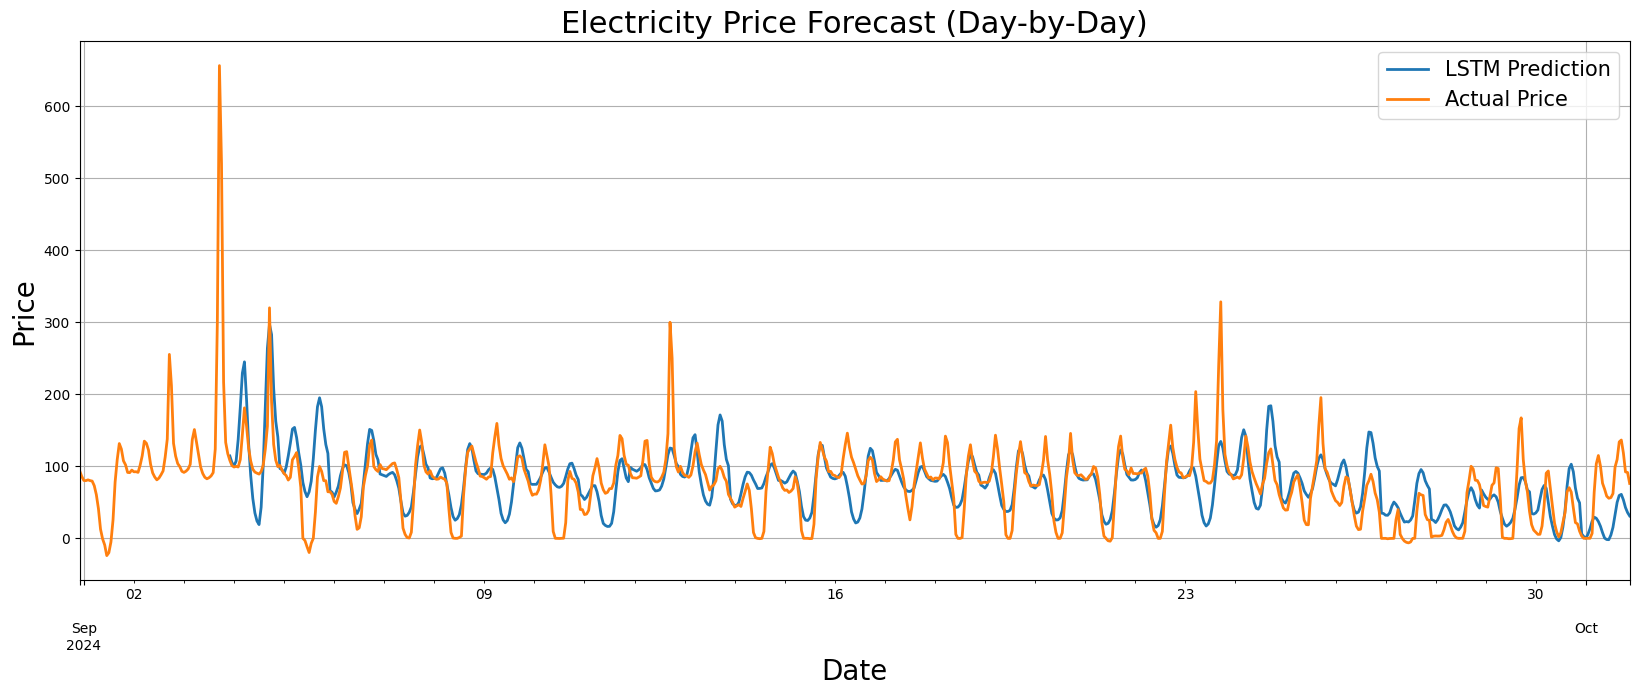

In [19]:
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(20, 7))

# Plot predictions for LSTM model
forecast_df.set_index('ds')['y_pred'].plot(ax=ax, linewidth=2, label='LSTM Prediction')

# Optional: Plot actual test values for comparison
test_df.set_index('ds')['y'].plot(ax=ax, linewidth=2, label='Actual Price')

# Formatting the plot
ax.set_title('Electricity Price Forecast (Day-by-Day)', fontsize=22)
ax.set_ylabel('Price', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
plt.show()

In [24]:
forecast_df.head(100)
forecast_df.info()

,ds,y_pred,y_actual
0,2024-09-03 22:00:00,114.332558,108.17
1,2024-09-03 23:00:00,105.128731,101.02
2,2024-09-04 00:00:00,100.616196,99.03
3,2024-09-04 01:00:00,107.279694,99.98
4,2024-09-04 02:00:00,137.628586,99.06
...,...,...,...
95,2024-09-07 21:00:00,97.794098,89.24
96,2024-09-07 22:00:00,83.889946,93.91
97,2024-09-07 23:00:00,82.714134,86.46
98,2024-09-08 00:00:00,83.172592,83.68


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate error metrics
mae = mean_absolute_error(forecast_df['y_actual'], forecast_df['y_pred'])
mse = mean_squared_error(forecast_df['y_actual'], forecast_df['y_pred'])
rmse = np.sqrt(mse)

# Print the results
print("Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Model Performance:
Mean Absolute Error (MAE): 26.26
Mean Squared Error (MSE): 1308.73
Root Mean Squared Error (RMSE): 36.18


In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Merge forecasted values with actual test data, selecting only the relevant columns
comparison_df = forecast_df[['ds', 'y_pred']].merge(test_df[['ds', 'y']], on='ds', how='inner')
comparison_df.rename(columns={'y': 'y_actual', 'y_pred': 'y_pred'}, inplace=True)

# Add a column for the day of the week (0=Monday, 1=Tuesday, ..., 6=Sunday)
comparison_df['day_of_week'] = comparison_df['ds'].dt.dayofweek

# Calculate and display MAE, MSE, and RMSE for each day of the week
metrics_by_day = {}

for day in range(7):
    # Filter data for each day of the week
    day_data = comparison_df[comparison_df['day_of_week'] == day]

    # Calculate the metrics for this day
    mae = mean_absolute_error(day_data['y_actual'], day_data['y_pred'])
    mse = mean_squared_error(day_data['y_actual'], day_data['y_pred'])
    rmse = np.sqrt(mse)

    # Store the metrics for each day
    metrics_by_day[day] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    }

    # Print the results for each day
    day_name = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][day]
    print(f"MAE of LSTM for {day_name} is: {mae:.2f}")
    print(f"MSE of LSTM for {day_name} is: {mse:.2f}")
    print(f"RMSE of LSTM for {day_name} is: {rmse:.2f}")
    print('-' * 50)

# Optionally, you can store these results in a DataFrame for easy viewing or further analysis
metrics_df = pd.DataFrame(metrics_by_day).T
print("\nMetrics by Day of the Week:")
print(metrics_df)

MAE of LSTM for Monday is: 32.69
MSE of LSTM for Monday is: 2120.28
RMSE of LSTM for Monday is: 46.05
--------------------------------------------------
MAE of LSTM for Tuesday is: 31.33
MSE of LSTM for Tuesday is: 1612.79
RMSE of LSTM for Tuesday is: 40.16
--------------------------------------------------
MAE of LSTM for Wednesday is: 28.32
MSE of LSTM for Wednesday is: 1382.87
RMSE of LSTM for Wednesday is: 37.19
--------------------------------------------------
MAE of LSTM for Thursday is: 32.71
MSE of LSTM for Thursday is: 2110.80
RMSE of LSTM for Thursday is: 45.94
--------------------------------------------------
MAE of LSTM for Friday is: 23.47
MSE of LSTM for Friday is: 806.06
RMSE of LSTM for Friday is: 28.39
--------------------------------------------------
MAE of LSTM for Saturday is: 19.20
MSE of LSTM for Saturday is: 643.88
RMSE of LSTM for Saturday is: 25.37
--------------------------------------------------
MAE of LSTM for Sunday is: 16.12
MSE of LSTM for Sunday is: 